# Imports

In [1]:
import numpy as np
import pandas as pd
import math
from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from dython.nominal import associations

df_train = pd.read_feather("data/df_train.feather").drop("index", axis=1)
df_test = pd.read_feather("data/df_test.feather").drop("index", axis=1)

In [2]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import set_config
set_config(display="diagram")

In [3]:
import json
with open("baseline.json", "r") as f:
    baseline = json.load(f)
    base_train_mae = baseline["mae_train"]
    base_test_mae = baseline["mae_test"]

def mae(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print('MAE on train data: ', train_mae)
    print('MAE on test data: ',  test_mae)
    return train_mae, test_mae

def compare_to_base(train_mae, test_mae):
    print("Difference with base train: ", train_mae - base_train_mae)
    print("Difference with base test: ", test_mae - base_test_mae)

# Cat / Num / Ord features

In [4]:
categorical_features = ['MS SubClass', 'MS Zoning',
        'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
        'Overall Cond', 'Roof Style',
        'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
        'Mas Vnr Type', 'Exter Qual',
        'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin Type 1',  'BsmtFin Type 2', 
        'Heating', 'Heating QC', 'Central Air',
        'Electrical',  'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
        'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
        'TotRms AbvGrd', 'Functional', 'Fireplaces' , 'Garage Type',
        'Garage Finish', 'Garage Cars', 
        'Garage Qual', 'Paved Drive', 'Mo Sold', 'Sale Type',
        'Sale Condition', 'Fireplace Qu', 'Pool QC', 'Garage Cond', 'Yr Sold'
        ] # 'Alley', 'Fence', 'Misc Feature'

numerical_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
        'Total Bsmt SF','1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
        'Gr Liv Area', 'Garage Area','Wood Deck SF',
        'Open Porch SF', '3Ssn Porch', 'Screen Porch',
        'Pool Area', 'Misc Val', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope',  'Overall Qual', 'Overall Cond',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 
                'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                'Garage Qual', 'Garage Cond', 'Pool QC', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add', "Garage Cars"]

In [5]:
print(len(categorical_features), len(numerical_features), len(ordinal_features))
ordinal_features = [feat for feat in ordinal_features if feat in categorical_features or feat in numerical_features]
categorical_features = [feat for feat in categorical_features if feat not in ordinal_features]
numerical_features = [feat for feat in numerical_features if feat not in ordinal_features]
print(len(categorical_features), len(numerical_features), len(ordinal_features))

54 21 25
32 18 25


# Add "House Area" feature

In [6]:
to_add = ["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area", "Wood Deck SF", "Open Porch SF"]
df_train["House Area"] = 0
df_test["House Area"] = 0
for col in to_add:
    df_train["House Area"] += df_train[col].fillna(0)
    df_test["House Area"] += df_test[col].fillna(0)
numerical_features.append("House Area")

# Outliers removal

In [7]:
def find_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [8]:
# df_train_clean = df_train.copy()
total_mask = []

for col, dist in zip(["Garage Yr Blt", "BsmtFin SF 1", "Open Porch SF", "Total Bsmt SF", "1st Flr SF"], [3, 3, 6, 4, 4]):
    upper, lower = find_boundaries(df_train, col, 4)
    mask = (df_train[col] < upper) & (df_train[col] > lower)
    total_mask.append(mask)

mask = reduce(np.logical_and, total_mask)
df_train = df_train[mask]

<AxesSubplot:xlabel='House Area', ylabel='SalePrice'>

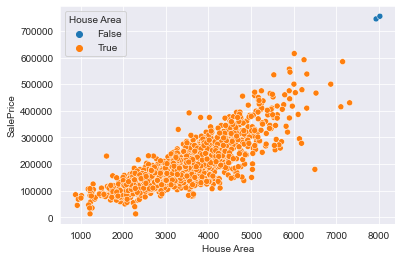

In [9]:
col = "House Area"
upper, lower = find_boundaries(df_train, col, 3)
mask = (df_train[col] < upper) & (df_train[col] > lower)

sns.scatterplot(data=df_train, x=col, y=df_train["SalePrice"], hue=mask)

# Check correlation

## With the target

In [10]:
corr = associations(df_train, compute_only=True)["corr"]

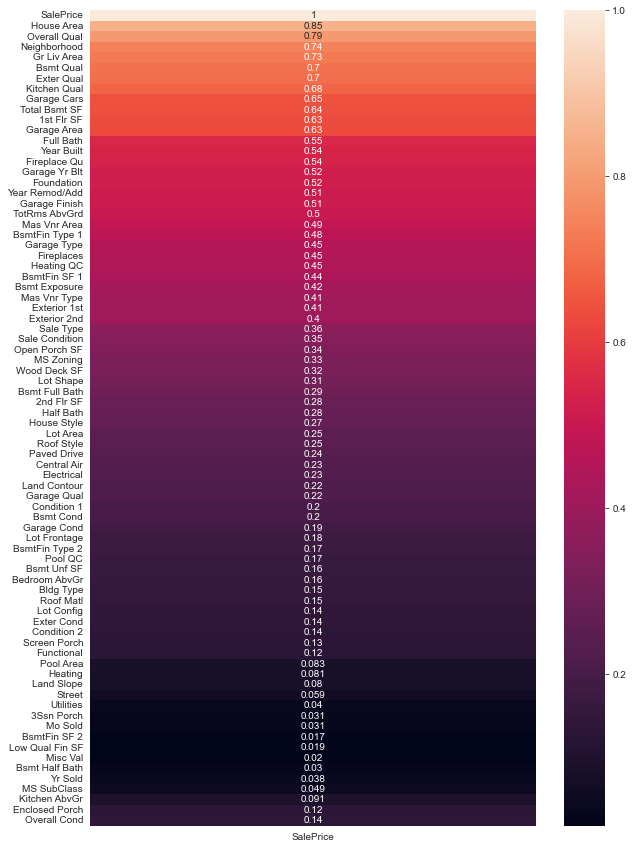

In [11]:
plt.figure(figsize=(10,15))
sns.heatmap(np.abs(corr.sort_values("SalePrice", ascending=False)[['SalePrice']]), annot=True)
plt.show()

In [12]:
# to_drop = corr[(np.abs(corr['SalePrice']) < 0.2)].index.to_list()
# df_train = df_train.drop(to_drop, axis=1)

# print(len(categorical_features), len(numerical_features), len(ordinal_features))
# ordinal_features = [feat for feat in ordinal_features if feat not in to_drop]
# categorical_features = [feat for feat in categorical_features if feat not in to_drop]
# numerical_features = [feat for feat in numerical_features if feat not in to_drop]
# print(len(categorical_features), len(numerical_features), len(ordinal_features))

## Multicolinearity
Note: We might also want to try a Variance Inflation Factor

In [13]:
corr = associations(df_train, compute_only=True)["corr"]

<AxesSubplot:>

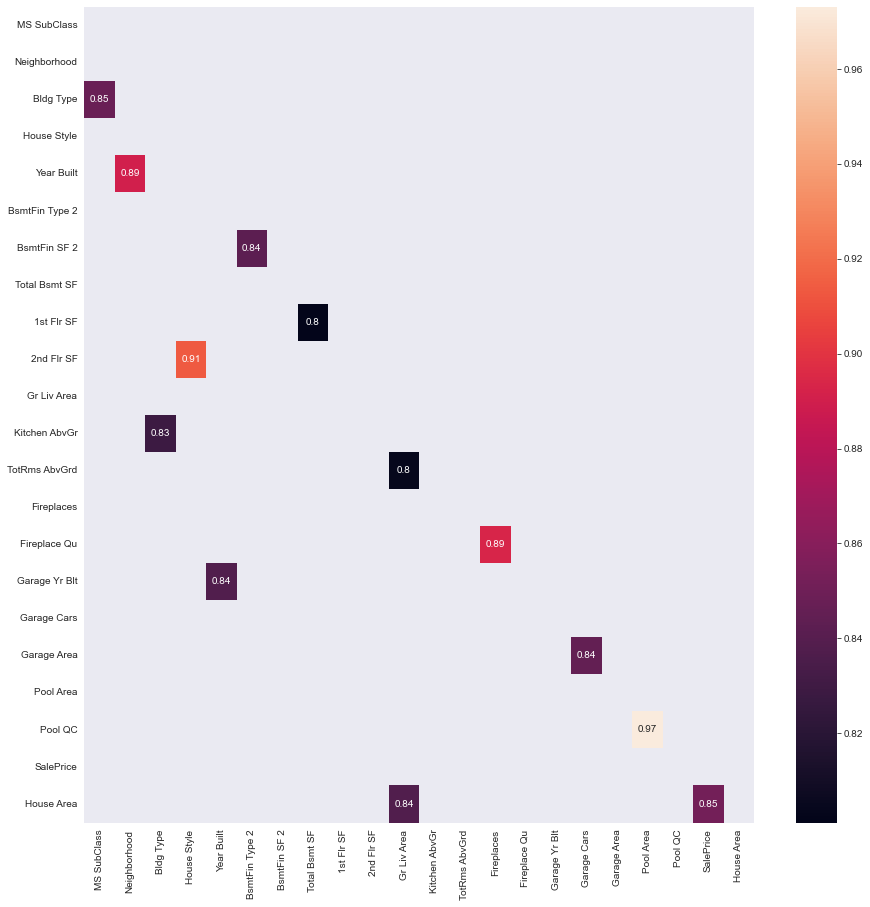

In [14]:
plt.figure(figsize=(15, 15))

filtered_corr = corr[(corr >= .8) & (corr != 1)].dropna(how="all", axis=0).dropna(how="all", axis=1)
mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

sns.heatmap(filtered_corr, mask=mask, annot=True)

In [15]:
# df_train.drop(["Year Built", "House Style", "1st Flr SF", "Gr Liv Area", "Fireplaces", "Garage Cars"], axis=1)

In [16]:
df_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',

In [17]:
# # numerical_transformer = SimpleImputer()
# categorical_transformer = Pipeline([
#     # ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("onehot", OneHotEncoder(handle_unknown="ignore"))
# ])

# # ("other", OrdinalEncoder(categories=[
# #     ["Reg", "IR1", "IR2", "IR3"],
# #     ["ELO", "NoSeWa", "NoSewr", "AllPub"],
# #     ["Gtl", "Mod", "Sev"],
# #     [None, "No", "Mn", "Av", "Gd"],
# #     [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
# #     [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
# #     ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
# #     [None, "Unf", "RFn", "Fin"]
# # ]), ["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 'BsmtFin Type 1', 'BsmtFin Type 2', "Functional", "Garage Finish"]),

# ordinal_encoding= ColumnTransformer(
#     transformers=[
#         ("other", OrdinalEncoder(categories=[
#             ["Reg", "IR1", "IR2", "IR3"],
#             [None, "No", "Mn", "Av", "Gd"],
#             [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
#             [None, "Unf", "RFn", "Fin"]
#         ]), ["Lot Shape", "Bsmt Exposure", 'BsmtFin Type 1', "Garage Finish"]),

#         ("qual_cond_nan", OrdinalEncoder(categories=
#         [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
#         ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual']
#         ),

#         ("qual_cond", OrdinalEncoder(categories=
#         [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(3)]),
#         ['Exter Qual', 'Heating QC', 'Kitchen Qual']),

#     ],
#     remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
# )

# ordinal_transformer = Pipeline([
#     ("ord_encoding", ordinal_encoding),
#     # ("imputing", SimpleImputer())
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         # ("num", [], numerical_features),
#         ("cat", categorical_transformer, categorical_features),
#         ("ord", ordinal_transformer, ordinal_features)
#     ],
#     remainder="passthrough"
# )

numerical_transformer = IterativeImputer()
categorical_transformer = Pipeline([
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    # ("onehot", OneHotEncoder(handle_unknown="igncoded_value", unknown_value=np.nan)),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.NaN)),
    ("imputer", IterativeImputer()),
    ("threshold", FunctionTransformer(np.round)),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Bsmt Exposure", 'BsmtFin Type 1', "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(3)]),
        ['Exter Qual', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", IterativeImputer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

In [92]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# pred = preprocessor.fit_transform(df_train)

# vif = pd.Series([variance_inflation_factor(df_train.values, i) for i in range(df_train.shape[1])], index=df_train.columns)
# vif = pd.Series([variance_inflation_factor(pred.toarray(), i) for i in range(pred.shape[1])])

# Using Recursive Feature Elimination (RFE) to narrow down the number of columns

In [ ]:
X_train = df_train.drop(["SalePrice"], axis=1)
y_train = df_train["SalePrice"]

In [ ]:
numerical_transformer = IterativeImputer()
ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Bsmt Exposure", 'BsmtFin Type 1', "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(3)]),
        ['Exter Qual', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", IterativeImputer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
rfe.fit(preprocessor.fit_transform(X_train), y_train)

RFE(estimator=RandomForestRegressor(), n_features_to_select=5)

In [ ]:
inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor())
])

rfe = RFE(estimator=inference_pipeline, n_features_to_select=5)#, importance_getter="model")
# rfe.fit(X_train[[numerical_features + ordinal_features][0]], y_train)
# rfe.fit(preprocessor.fit_transform(X_train), y_train)

In [ ]:
X_train[numerical_features + ordinal_features].loc[:, rfe.support_]

,Lot Area,Gr Liv Area,House Area,Garage Qual,Year Built
0,10400,1370,2939.0,TA,1976
1,28698,2126,4163.0,TA,1967
2,9842,1224,1686.0,TA,1962
3,7200,1040,1460.0,TA,1949
5,10029,2060,3960.0,TA,1988
...,...,...,...,...,...
2339,41600,1424,3496.0,TA,1969
2340,7750,1414,2659.0,TA,2002
2341,8791,1728,3537.0,TA,2003
2342,7308,1740,2901.0,Fa,1920


In [93]:
numerical_transformer = IterativeImputer()
ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            [None, "Unf", "RFn", "Fin"]
        ]), ["Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=[
            ["Po", None, "Fa", "TA", "Gd", "Ex"]
        ]), ['Garage Qual']
        )
    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", IterativeImputer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, ["Lot Area", "BsmtFin SF 1", "2nd Flr SF", "Gr Liv Area", "Garage Area", "House Area"]),
        ("ord", ordinal_transformer, ["Garage Finish", "Garage Qual", "Year Built", "Year Remod/Add"])
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [94]:
rfe_columns = X_train[numerical_features + ordinal_features].loc[:, rfe.support_].columns
inference_pipeline.fit(X_train[rfe_columns], y_train)

NameError: name 'rfe' is not defined

In [ ]:
X_test = df_test.drop("SalePrice", axis=1)
y_test = df_test["SalePrice"]

In [ ]:
compare_to_base(*mae(inference_pipeline, X_train[rfe_columns], y_train, X_test[rfe_columns], y_test))

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [19]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [68]:
most_frequent_values = df_train.value_counts().idxmax()
fillna_dict = {col: most_frequent_values[i] for i, col in enumerate(df_train.columns)}

df_train_cb = df_train.fillna(fillna_dict)
X_train_cb = df_train_cb.drop("SalePrice", axis=1)
y_train_cb = df_train_cb["SalePrice"]

df_test_cb = df_test.fillna(fillna_dict)
X_test_cb = df_test_cb.drop("SalePrice", axis=1)
y_test_cb = df_test_cb["SalePrice"]

In [70]:
model = CatBoostRegressor(iterations=5000)

train_pool = Pool(X_train_cb, y_train_cb, feature_names=list(X_train_cb.columns), cat_features=list(df_train.select_dtypes("object").columns))
test_pool = Pool(X_test_cb, y_test_cb, feature_names=list(X_test_cb.columns), cat_features=list(df_train.select_dtypes("object").columns))

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(X_train_cb.columns),
    num_features_to_select=10,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [71]:
final_cols = summary["selected_features_names"]

# Regularization and final model

In [73]:
print([f for f in numerical_features if f in final_cols])
print([f for f in categorical_features if f in final_cols])
print([f for f in ordinal_features if f in final_cols])

['BsmtFin SF 1', 'Gr Liv Area', 'House Area']
['Neighborhood', 'Fireplaces']
['Overall Qual', 'Bsmt Qual', 'Kitchen Qual', 'Year Built', 'Year Remod/Add']


In [34]:
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]

X_test = df_test.drop("SalePrice", axis=1)
y_test = df_test["SalePrice"]

In [90]:
numerical_transformer = IterativeImputer()
categorical_transformer = Pipeline([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.NaN)),
    ("imputer", IterativeImputer()),
    ("threshold", FunctionTransformer(np.round)),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"]]),
        ['Bsmt Qual']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"]]),
        ['Kitchen Qual']
        ),
    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", IterativeImputer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, [f for f in numerical_features if f in final_cols]),
        ("cat", categorical_transformer, [f for f in categorical_features if f in final_cols]),
        ("ord", ordinal_transformer, [f for f in ordinal_features if f in final_cols])
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=25))
])

inference_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', IterativeImputer(),
                                                  ['BsmtFin SF 1',
                                                   'Gr Liv Area',
                                                   'House Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   IterativeImputer()),
                                                                  ('threshold',
                                                                   FunctionTransformer(func=<function round_ at 0x1094320e0>)),
                                                                  ('onehot',
                                                                   OneHotEnc...
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('qual_cond_nan',
                                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                                None,
                                                                                                                                'Fa',
                                                                                                                                'TA',
                                                                                                                                'Gd',
                                                                                                                                'Ex']]),
                                                                                                    ['Bsmt '
                                                                                                     'Qual']),
                                                                                                   ('qual_cond',
                                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                                'Fa',
                                                                                                                                'TA',
                                                                                                                                'Gd',
                                                                                                                                'Ex']]),
                                                                                                    ['Kitchen '
                                                                                                     'Qual'])])),
                                                                  ('imputing',
                                                                   IterativeImputer())]),
                                                  ['Overall Qual', 'Bsmt Qual',
                                                   'Kitchen Qual', 'Year Built',
                                                   'Year Remod/Add'])])),
                ('model', Lasso(alpha=25))])

In [91]:
compare_to_base(*mae(inference_pipeline, X_train, y_train, X_test, y_test))

MAE on train data:  18739.432403557494
MAE on test data:  20470.7254562214
Difference with base train:  -1549.9005108933961
Difference with base test:  -854.191037749013
